# Diffusion for 256 x 256

In [2]:
import jupyter_black

import sys, os, shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [3]:
# Custom modules
from dataset import create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import (
    train,
    count_fid_metric,
    show_grid_samples,
    generate_and_save_samples,
)

In [4]:
# Dirs
sample_dir = "/usr/src/samples_substrate"
substrate_dir = "/usr/src/data/substrates"
part_substrate_dir = "/usr/src/data/part_substrates"

image_size = 256

In [ ]:
# Cut part substrates
get_part_substrates_from_all(
    substrate_dir, part_substrate_dir, part_size=(image_size, image_size)
)

In [6]:
# Settings
channels = 1
batch_size = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the dataset of substrates
substrate_dataset = create_substrate_dataset(part_substrate_dir)

# Create the dataloader for training
train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Chech dataset and trainloader

print(f"Len of dataset:  {len(substrate_dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  5400 images
Len of trainloader:  540 batches
Shape of batch:  torch.Size([10, 1, 256, 256])


In [8]:
# Initialization of the diffusion

timesteps = 300
diffusion = Diffusion(timesteps)

In [17]:
# Initialization of the denoising model and optimizer

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
# Training model (256x256 about 11 minutes on NVIDIA)

epochs = 5
log_path = "logging_substrates"
log_interval = len(train_loader) // 5

loss_progress = train(
    model, diffusion, timesteps, train_loader, epochs, optimizer, device, log_path, log_interval
)

----- Epoch 1 -----
Loss: 0.41550540924072266


Loss: 0.0074116820469498634
Loss: 0.00914283748716116
Loss: 0.009146058931946754
Loss: 0.03769039735198021


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.017611188814044
Loss: 0.01966789923608303
Loss: 0.0213748998939991
Loss: 0.028297370299696922
Loss: 0.008948350325226784


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.0030595283024013042
Loss: 0.0055517698638141155
Loss: 0.001227065920829773
Loss: 0.0022136501502245665
Loss: 0.0007142738322727382


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.004108085762709379
Loss: 0.005925736855715513
Loss: 0.0008549437043257058
Loss: 0.003825650317594409
Loss: 0.016254350543022156


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.001612854772247374
Loss: 0.001221960294060409
Loss: 0.011845524422824383
Loss: 0.0012338671367615461
Loss: 0.0032293430995196104


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

In [20]:
# Save trained model

torch.save(model, f"substrate_denoise_model_{epochs}_epochs.pt")

In [ ]:
# Load pretrained model

model = torch.load("substrate_denoise_model_5_epochs.pt")
model.eval()

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

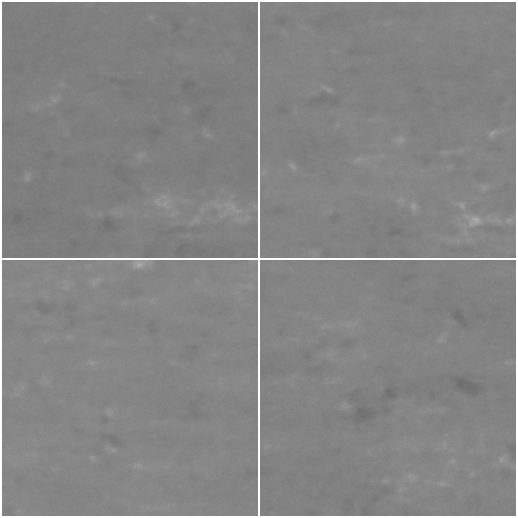

In [11]:
# Create grid of generated samples and show it

n_samples = 4
samples = show_grid_samples(
    n_samples, diffusion, model, image_size, channels, "grid_substrates"
)

In [12]:
# Generate many new separate samples and save them

generate_and_save_samples(sample_dir, 30, 10, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

In [13]:
# Count FID metric

feature = 2048
print(
    f"feature = {feature}, FID =",
    count_fid_metric(
        train_loader, diffusion, model, image_size, channels, 100, feature
    ),
)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

100 samples are generated, time = 308.102 sec
FID is computed, time = 38.120 sec
feature = 2048, FID = tensor(142.4040)
